# A debugging tool to see if we're overfitting on a small dataset

In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from copy import deepcopy
import secrets
import os

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools
from primo.models.cas9_keras import log_multisite_predictor

# Enable memory growth so that we only use as much GPU memory as needed.
# By default, tensorflow will reserve nearly all of the GPU memory.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0t5jnzrz because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=5*10**4
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# To see how this value was derived, please consult the Materials and Methods subsection under 
# Feature Extraction section in Bee et. al. 2021. 
similarity_threshold = 75
# Intuitively determined:
batch_size = 150
val_batch_size = 150

def keras_batch_generator(dataset_batch_generator):
    # Yield datasets
    # Each sample is a triplet with known similar and dissimilar images, so the y_true
    # value is unused in the loss function.
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by
        #   enumerating all the images in the dataset (before splitting them into 
        #   test/train/validate datasets)
        # triplets: A set of three image feature vectos containing anchor, positive (similar) 
        #   image, and negative (dissimilar) image
        indices, triplets = next(dataset_batch_generator)
        yield triplets, np.zeros(len(triplets))

train_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        train_dataset.random_features(batch_size),
        similarity_threshold
    )
)

val_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        validation_dataset.random_features(val_batch_size),
        similarity_threshold
    )
)

train_inputs, train_targets = next(train_batch_generator)
val_inputs, val_targets = next(train_batch_generator)

switching to train_c.h5 and train_4.h5


In [3]:
# The reason the default encoder input is a 4096-dimensional vector is
# because we're representing our images through an embedding that was learned
# by a computer vision model known as VGG [1]. We're borrowing the output of the
# 2nd fully-connected layer (i.e. the FC2), which spits out a 4096-by-1 vector.
#
# If you're very curious about VGG's innerworkings, you can see an example tensorflow
# implementation here [2, 3].
#
# Note for future users: If you ever decide to use a different model VGG16,
# you'd probably want to change the input dimension here.
#
# [1] - https://neurohive.io/en/popular-networks/vgg16/
# [2] - https://www.cs.toronto.edu/~frossard/post/vgg16/
# [3] - https://github.com/kentsommer/VGG16-Image-Retrieval/blob/master/vgg16_example.py#L237
INPUT_FEATURE_SIZE = 4096 

# Each CAS site is 20nt, so the output length should be 20nt for single
# site, and a multiple of 20nt for multiple sites.
OUTPUT_LEN = 20

# Temperature used for softmax calculation
SOFTMAX_TEMP = 1.0

# Optionally, load a previously saved model to continue training
MODEL_FILE=None

def hardmax(temperature):
    def hardmax_f(x):
        y = tf.nn.softmax(x / temperature)
        y_hard = tf.one_hot(tf.argmax(y, -1), 4)
        y = tf.stop_gradient(y_hard - y) + y
        return y
    return hardmax_f

# Create the keras model for a single encoder.
encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Lambda(hardmax(SOFTMAX_TEMP)),
], name='encoder')

# Start with previously trained model if a filename is provided
if MODEL_FILE is not None:
    encoder = tf.keras.models.load_model(MODEL_FILE)

# First input is anchor, second is a positive sample, third is a negative sample
X_triplets = layers.Input([3, INPUT_FEATURE_SIZE])

# Essentially, we started with a batch of feature-vector triplets...
# ...And turned them into a triplet of feature-vector batches.
X1, X2, X3 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:], X[:,2,:]))(X_triplets)

# Layer to compute euclidean distances between the triplet pairs for convenience
distances = layers.Lambda(lambda Xs:
                          (
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)),
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[2]), axis=1))
                          ))([X1,X2,X3])

# Independently transforms the batches of feature vectors into one-hot encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)
S3 = encoder(X3)

# Glue them back together! Back into a batch of feature vector triplets.
S_triplets = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2,S3])

# Dimensions: (batch_size x 80 x 4 x 3 ) (i.e. batch size x DNA length x # of nucleotides x 3)
# Swaps dimensions for the loss function, which wants (batch-size x 3 x DNA length x 4)
S_triplets_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_triplets)

encoder_trainer = tf.keras.Model(inputs=X_triplets, outputs=S_triplets_T)

In [4]:
# Defined the loss function, and metrics used for training

def UniquenessMetric(y_true, y_pred):
    seqs = encoder_trainer(train_inputs)
    # Reduce seqs to a single base (e.g. [0.3, 0.1, 0.5, 0.1] -> [2])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def RecallMetric(y_true, y_pred):
    Yp = log_multisite_predictor(tf.gather(y_pred, [0, 1], axis=1))
    return tf.reduce_mean(tf.cast(Yp > -2.0, tf.float32))

def NegRecallMetric(y_true, y_pred):
    Yn = log_multisite_predictor(tf.gather(y_pred, [0, 2], axis=1))
    return tf.reduce_mean(tf.cast(Yn > -2.0, tf.float32))

class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(2)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)


    def on_epoch_end(self, epoch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping after Epoch {epoch}")
          self.model.stop_training = True

class TripletLoss(object):

    def __call__(self, y_true, y_pred):
        """
        y_pred is triplets of (anchor, positive, negative), with dimensions
        batch_size x 3 x 20 x 4
        """
        pos_distance = -log_multisite_predictor(tf.gather(y_pred, [0,1], axis=1))
        neg_distance = log_multisite_predictor(tf.gather(y_pred, [0,2], axis=1))

        # Compute loss function which penalizes low activation rate for positive 
        # pairs, and high activation rate for negative pairs, ignoring samples which
        # are above (positive) or below (negative) thresholds -- i.e. samples which 
        # are already well trained are ignored.
        return tf.maximum(pos_distance, 0.5) + tf.maximum(neg_distance, -3.0)


In [18]:
# ###
# # Train on a single small batch
# ###
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-2),
    TripletLoss(),
    run_eagerly=True,
    metrics=[UniquenessMetric])
history = encoder_trainer.fit(train_inputs, train_targets, validation_data=(val_inputs, val_targets), epochs=50)

Epoch 1/50
5/5 [==============================] - 2s 386ms/step - loss: -2.1392 - UniquenessMetric: 0.2093 - val_loss: -0.7557 - val_UniquenessMetric: 0.2000
Epoch 2/50
5/5 [==============================] - 2s 381ms/step - loss: -2.1585 - UniquenessMetric: 0.2173 - val_loss: -0.8455 - val_UniquenessMetric: 0.2200
Epoch 3/50
5/5 [==============================] - 2s 382ms/step - loss: -2.1321 - UniquenessMetric: 0.2107 - val_loss: -0.8488 - val_UniquenessMetric: 0.2067
Epoch 4/50
5/5 [==============================] - 2s 383ms/step - loss: -2.1327 - UniquenessMetric: 0.2067 - val_loss: -0.8136 - val_UniquenessMetric: 0.2267
Epoch 5/50
5/5 [==============================] - 2s 380ms/step - loss: -2.1267 - UniquenessMetric: 0.2133 - val_loss: -0.8221 - val_UniquenessMetric: 0.2067
Epoch 6/50
5/5 [==============================] - 2s 417ms/step - loss: -2.1675 - UniquenessMetric: 0.2027 - val_loss: -0.7931 - val_UniquenessMetric: 0.1933
Epoch 7/50
5/5 [==============================] - 2s

<IPython.core.display.Javascript object>


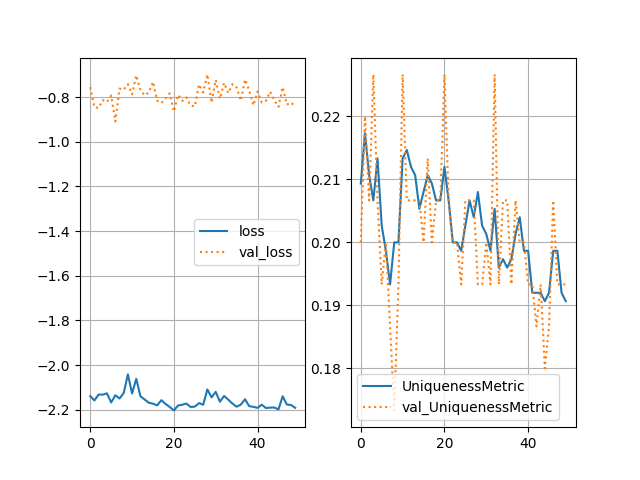

In [19]:
# Plot training history
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]
axes = fig.subplots(int(len(lines)/2), 2)
for i in range(len(lines)):
    label = lines[i]
    ax = axes.flatten()[i]
    val_label = 'val_' + label
    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
        ax.grid()
    ax.legend()

In [ ]:

encoder.save('/tf/primo/data/models/small_encoder.h5')

### Now grab the data you used for training and validation and simulate doing Cas9 similarity search retrieval

In [23]:
encoded_seqs = encoder_trainer.predict(train_inputs)
Sp = tf.gather(encoded_seqs, [0, 1], axis=1)
Sn = tf.gather(encoded_seqs, [0, 2], axis=1)


Yp = log_multisite_predictor(Sp).numpy()
Yn = log_multisite_predictor(Sn).numpy()

threshold = -1

matchedP = (Yp > threshold).sum()
matchedN = (Yn < threshold).sum()

print(f"Positive Accuracy: {matchedP} of {len(Yp)}")
print(f"Negative Accuracy: {matchedN} of {len(Yn)}")


Positive Accuracy: 142 of 150
Negative Accuracy: 147 of 150
